In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit 

from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# EDA

In [3]:
data = pd.read_csv('/content/drive/My Drive/Digit/train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


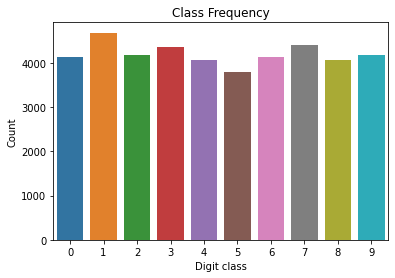

In [4]:
ax = sns.countplot(x = 'label', data = data)
ax.set(xlabel='Digit class', ylabel='Count', title = 'Class Frequency')
plt.show()

In [5]:
print(f"Number of missing pixels: {data.iloc[:,1:].isnull().any().sum()}")
print(f"Number of missing labels: {data.iloc[:,0].isnull().any().sum()}")

Number of missing pixels: 0
Number of missing labels: 0


### Create training and validation sets

In [0]:
# Create validation set, stratified based on digit class
s = StratifiedShuffleSplit(test_size=0.1, random_state=42)

for train_index, val_index in s.split(data, data["label"]): 
    train = data.loc[train_index]
    val = data.loc[val_index]
    
train.reset_index(inplace=True, drop=True) 
val.reset_index(inplace=True, drop=True) 

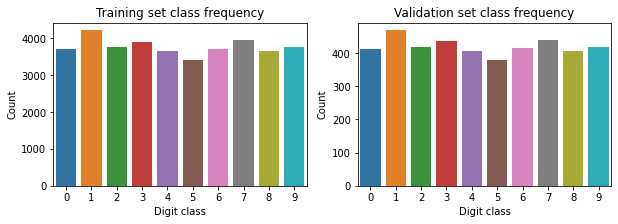

In [7]:
# Distribution of digit class in train and validation sets
fig, axes = plt.subplots(1, 2, figsize=(10,3))

sns.countplot(x = 'label', data = train, ax=axes[0])
axes[0].set(xlabel='Digit class', ylabel='Count', title='Training set class frequency')

sns.countplot(x = 'label', data = val, ax=axes[1])
axes[1].set(xlabel='Digit class', ylabel='Count', title='Validation set class frequency')

plt.show()

# Data Preprocessing

In [0]:
X_train = np.array(train.iloc[:,1:])
y_train = np.array(train['label'])
X_val = np.array(val.iloc[:,1:])
y_val = np.array(val['label'])

In [0]:
X_train = X_train / 255.0 # Normalize training input
X_val = X_val / 255.0 # Normalize validation input

X_train = X_train.reshape(-1,28,28,1) # Reshape training input into 3D arrays
X_val = X_val.reshape(-1,28,28,1) # Reshape validatin input into 3D arrays

y_train = to_categorical(y_train, num_classes = 10) # One-hot-encode training labels
y_val = to_categorical(y_val, num_classes = 10) # One-hot-encode validation labels

In [10]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (37800, 28, 28, 1)
Shape of X_val: (4200, 28, 28, 1)
Shape of y_train: (37800, 10)
Shape of y_val: (4200, 10)


# Train Model

In [12]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = 5, padding = "same", activation = "relu", input_shape = [28,28,1]),
    MaxPooling2D (pool_size = 2, strides = 2),
    Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    MaxPooling2D (pool_size = 2, strides = 2),    
    Flatten(),
    Dense(256, activation = "relu"), 
    Dropout(0.5),  
    Dense(10, activation = "softmax")
])

model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()


# Callbacks
checkpoint = ModelCheckpoint("/content/drive/My Drive/Digit/digit_model_2.h5",                                                 
                              monitor = 'val_loss',                                                
                              save_best_only=True) # save the model with the lowest val_loss

early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=1, verbose=1, factor=0.5)


#Data Augmentation
datagen = ImageDataGenerator(rotation_range=10, 
                             zoom_range = 0.1, 
                             width_shift_range=0.1,  # horizontal shift (relative to total width)
                             height_shift_range=0.1)  # vertical shift (relative to total height)
datagen.fit(X_train)


#Train model
batch_size = 64
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size= batch_size),
                              epochs = 15, 
                              validation_data = (X_val,y_val),
                              verbose = 2, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[checkpoint, lr_scheduler, early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               803072    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

# Evaluate Model

### Plot loss VS epoch

In [0]:
def plot_graphs(history, metric):    
    joblib.dump(history.history[metric], "/content/drive/My Drive/Digit/train_" + metric + ".pkl") #save training metric
    joblib.dump(history.history['val_' + metric], "/content/drive/My Drive/Digit/val_" + metric + ".pkl") #save validation metric
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])

In [0]:
# Ignore this cell. I had to reload because there were some issues with x and y label with matplotlib
from importlib import reload
plt=reload(plt)

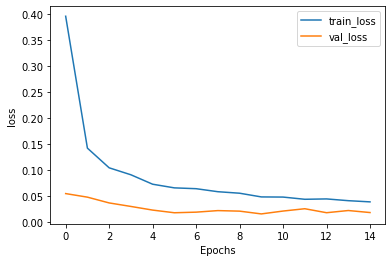

In [14]:
plot_graphs(history, "loss")

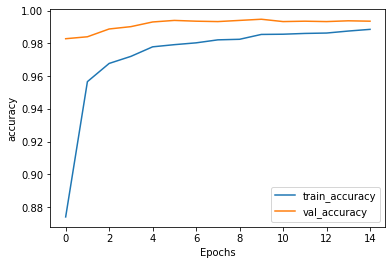

In [15]:
plot_graphs(history, "accuracy")

### Confusion matrix

In [16]:
y_pred = model.predict (X_val) # output class probabilities
y_pred = np.argmax (y_pred,axis = 1)  # class with highest prob (i.e. predicted class)

y_true = np.argmax (y_val,axis = 1) # class with prob of 1 (i.e. true class)

conf = confusion_matrix (y_true, y_pred) 
print(conf)

array([[412,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 464,   1,   0,   0,   0,   0,   3,   0,   0],
       [  1,   0, 414,   0,   0,   0,   0,   3,   0,   0],
       [  0,   0,   1, 432,   0,   0,   0,   1,   1,   0],
       [  0,   0,   0,   0, 406,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0, 375,   3,   0,   1,   1],
       [  1,   1,   0,   0,   0,   0, 412,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 440,   0,   0],
       [  0,   0,   0,   0,   1,   0,   1,   0, 403,   1],
       [  0,   0,   0,   0,   3,   0,   0,   1,   0, 415]])

In [29]:
print(f"Weighted F1 score is: {f1_score(y_true,y_pred, average='weighted'):.3f}")

Weighted F1 score is: 0.994


Text(0, 0.5, 'True class')

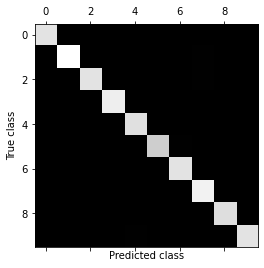

In [30]:
plt.matshow(conf, cmap=plt.cm.gray) 
plt.xlabel('Predicted class')
plt.ylabel('True class')

Digits are correctly classified for the most part

### Error Rates

Text(0, 0.5, 'True class')

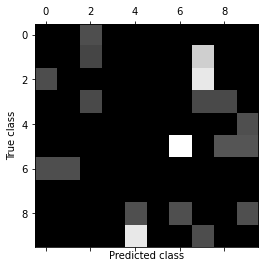

In [66]:
row_sum = conf.sum(axis=1, keepdims=True) # total images in each class
norm_conf = conf / row_sum * 100 # normalized error
np.fill_diagonal(norm_conf, 0) # without this line, the diagonals will be very bright, and it will be hard to visualize the errors

plt.matshow(norm_conf, cmap = plt.cm.gray) # brighter = higher error rates
plt.xlabel('Predicted class')
plt.ylabel('True class')

Notes on bright spots (high normalized error)
* 3 images (0.8%) of Digit 5 is misclassified as 6
* 3 images (0.6%) of Digits 1 is misclassified as 7
* 3 images (0.7%) of Digits 2 is misclassified as 7
* 3 images (0.7%) of Digits 9 is misclassified as 4


# Predict and Submit

In [0]:
model = load_model('/content/drive/My Drive/Digit/digit_model_2.h5') 

In [0]:
submission = pd.read_csv('/content/drive/My Drive/Digit/test.csv')
submission = submission / 255.0 #Normalize
submission = submission.values.reshape(-1,28,28,1) 

In [0]:
submission_y_pred = model.predict(submission)
submission_y_pred = np.argmax(submission_y_pred,axis = 1)

In [0]:
# Create dataframe and write to file

df = pd.DataFrame({'ImageId': range(1,28001),                              
                   'Label': submission_y_pred})

df.to_csv('/content/drive/My Drive/Digit/mnist2.csv', index = False)